# EDA on individual census data

In [11]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/CID_Food_Access/data/clean/shelter_census_clean.csv')

In [3]:
df.head()

,report_date,borough,community_districts,family_with_children_commercial_hotel,family_with_children_shelter,family_cluster
0,2026-01-31,Queens,8.0,158.0,297.0,0.0
1,2026-01-31,Queens,7.0,76.0,0.0,0.0
2,2026-01-31,Queens,6.0,0.0,244.0,0.0
3,2026-01-31,Bronx,1.0,223.0,1463.0,0.0
4,2026-01-31,Bronx,10.0,0.0,529.0,0.0


In [16]:
df.isnull().sum()

report_date                                 0
borough                                     0
community_districts                        20
family_with_children_commercial_hotel     563
family_with_children_shelter              387
family_cluster                           1436
year                                        0
dtype: int64

#### Assumption on why we are imputing the nulls
In this dataset, we are assuming that null values in the shelter category columns do not represent missing or unknown data, but rather indicate that there were zero families recorded in that specific shelter type for that community district and month. Since the data is reported as counts, and other months show valid numeric entries for the same districts, it is reasonable to interpret these blanks as the absence of families in that category rather than uncollected data. Therefore, we impute null values with 0 to accurately reflect no recorded presence while preserving the integrity of the aggregation process. This allows us to compute yearly averages without artificially excluding districts or inflating counts.

In [ ]:
df[
    [
        'family_with_children_commercial_hotel',
        'family_with_children_shelter',
        'family_cluster'
    ]
] = df[
    [
        'family_with_children_commercial_hotel',
        'family_with_children_shelter',
        'family_cluster'
    ]
].fillna(0)

report_date                               0
borough                                   0
community_districts                      20
family_with_children_commercial_hotel     0
family_with_children_shelter              0
family_cluster                            0
year                                      0
dtype: int64

In [19]:
# drop the cdta nulls
df = df.dropna(subset=['community_districts'])
df.isnull().sum()

report_date                              0
borough                                  0
community_districts                      0
family_with_children_commercial_hotel    0
family_with_children_shelter             0
family_cluster                           0
year                                     0
dtype: int64

In [20]:
df['report_date'] = pd.to_datetime(df['report_date'])

In [21]:
# filter the data to be only 2023 to 2024
df = df[(df['report_date'].dt.year >= 2023) & (df['report_date'].dt.year <= 2024)]

In [22]:
# sanity check
df['report_date'].dt.year.value_counts()

report_date
2024    708
2023    708
Name: count, dtype: int64

In [23]:
# create a year column
df['year'] = df['report_date'].dt.year

In [24]:
df.keys()

Index(['report_date', 'borough', 'community_districts',
       'family_with_children_commercial_hotel', 'family_with_children_shelter',
       'family_cluster', 'year'],
      dtype='object')

In [25]:
cdta_yearly = (df.groupby(['community_districts', 'year'], as_index=False).mean(numeric_only=True))

#### This process gives us 
- One row per CDTA per year
- Clean yearly averages
- No summing across categories

In [26]:
cdta_yearly['shelter_rank'] = (
    cdta_yearly
    .groupby('year')['family_with_children_shelter']
    .rank(method='dense', ascending=False)
)


In [27]:
# display the top 10
cdta_yearly.sort_values(['year','shelter_rank']).groupby('year').head(10)

,community_districts,year,family_with_children_commercial_hotel,family_with_children_shelter,family_cluster,shelter_rank
30,16.0,2023,547.833333,2442.166667,0.0,1.0
32,17.0,2023,265.250000,1186.416667,0.0,2.0
6,4.0,2023,384.937500,986.270833,0.0,3.0
34,18.0,2023,214.250000,932.333333,0.0,4.0
8,5.0,2023,777.000000,788.541667,0.0,5.0
10,6.0,2023,439.312500,684.166667,0.0,6.0
24,13.0,2023,150.375000,652.666667,0.0,7.0
16,9.0,2023,64.145833,591.625000,0.0,8.0
4,3.0,2023,447.966667,564.716667,0.0,9.0
22,12.0,2023,939.083333,520.291667,0.0,10.0


In [ ]:
cdta_yearly['high_shelter_flag'] = (
    cdta_yearly
    .groupby('year')['family_with_children_shelter']
    .transform(lambda x: x >= x.quantile(0.75))
).astype(int)

,community_districts,year,family_with_children_commercial_hotel,family_with_children_shelter,family_cluster,shelter_rank,high_shelter_flag
0,1.0,2023,1076.733333,423.216667,0.0,11.0,0
1,1.0,2024,1373.966667,424.916667,0.0,11.0,0
2,2.0,2023,312.650000,248.716667,0.0,15.0,0
3,2.0,2024,389.733333,230.300000,0.0,15.0,0
4,3.0,2023,447.966667,564.716667,0.0,9.0,0


In [ ]:
cdta_yearly.groupby('year')['high_shelter_flag'].value_counts()

year  high_shelter_flag
2023  0                    13
      1                     5
2024  0                    13
      1                     5
Name: count, dtype: int64

<Axes: title={'center': 'family_with_children_shelter'}, xlabel='year'>

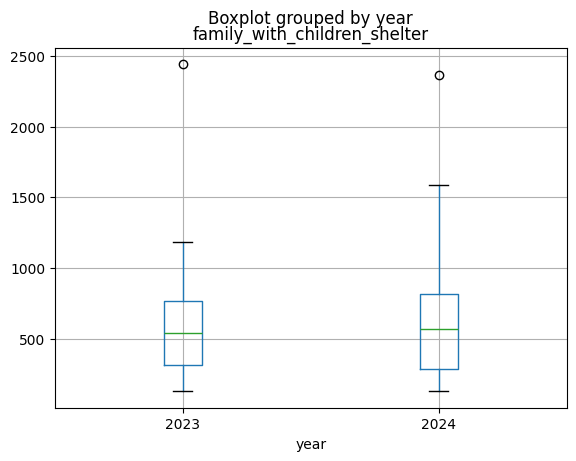

In [31]:
cdta_yearly.boxplot(
    column='family_with_children_shelter',
    by='year'
)

In [ ]:
cdta_yearly.groupby('year')['family_with_children_shelter'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2023,18.0,643.271065,538.318824,131.458333,313.468750,542.504167,762.447917,2442.166667
2024,18.0,657.076389,561.992945,126.458333,287.447917,566.870833,817.010417,2367.916667


#### Key takeaway:
- The average shelter population per CDTA slightly increased from 2023 (~643) to 2024 (~657).
- The median also increased (542 → 567), suggesting the rise isn’t just driven by outliers
- The distribution is right-skewed, with very high maximum values in both years (around 2400+), meaning a few CDTAs carry a disproportionately large shelter burden.
- The spread (std) is high in both years, indicating significant variation across districts.
    - Overall, shelter concentration patterns look stable but slightly elevated in 2024.

In [ ]:
cdta_final = (
    cdta_yearly
    .groupby('community_districts', as_index=False)
    ['family_with_children_shelter']
    .mean()
)

In [38]:
cdta_final['high_shelter_flag'] = (
    cdta_final['family_with_children_shelter'] 
    >= cdta_final['family_with_children_shelter'].quantile(0.75)
).astype(int)

In [39]:
# sanity check timeee
cdta_final['high_shelter_flag'].value_counts()

high_shelter_flag
0    13
1     5
Name: count, dtype: int64

In [40]:
cdta_final.sort_values(
    by='family_with_children_shelter',
    ascending=False
).head()

,community_districts,family_with_children_shelter,high_shelter_flag
15,16.0,2405.041667,1
16,17.0,1384.958333,1
3,4.0,972.822917,1
17,18.0,918.875000,1
4,5.0,812.052083,1


# Summarization of EDA so far
## objective of this EDA section
- The goal of this analysis was to define and measure shelter concentration across community districts (CDTAs) for families with children during 2023–2024. This creates a clean, defensible variable representing shelter burden that can later be used in broader analysis.

### What I measured
- I focused on `family_with_children_shelter` and intentionally did not combine `family_with_children_commercial_hotel` and `family_cluster` because those categories may overlap and could risk double counting. Keeping them separate preserves clarity and integrity.

#### What I did
- I filtered the dataset -- restricted the data to 2023 and 2024 only to align with our analysis period.
- Null values in shelter category columns were imputed as 0.
    - __Assumption:__ These represent no recorded families, not missing data.
    - Rows missing community_districts were removed.
        - __Assumption:__ Without a geographic identifier, they cannot be reliably used.

- Aggregated to yearly averages and calculated the mean of `family_with_children_shelter`. Which gave the average number of families with children in shelter per district per year. This is not a total count!! It represents average ongoing shelter burden within each district.

- Collapsed 2023–2024 into one value per district: 
    - then averaged the yearly values again to create:
        - One average shelter concentration number per CDTA across 2023–2024.
        - This number answers: On average, how many families with children are in shelter in this district at a given time during 2023–2024?

- Created a high shelter concentration indicator - calculated the 75th percentile of the district averages.
     - Districts at or above this cutoff were labeled: `high_shelter_flag = 1`, others labeled as `high_shelter_flag = 0`
    - This created a clean binary classification of: 
        - High shelter concentration districts (top 25%)
        - Lower concentration districts (bottom 75%)

- **Key Results**
    - Total districts analyzed: 18
    - High shelter districts identified: 5
    - Lower shelter districts: 13

- **From descriptive statistics:**
    - Average shelter population slightly increased from 2023 to 2024
    - Median also increased, suggesting the increase is not driven solely by outliers
    - Distribution is right-skewed, meaning a small number of districts carry a disproportionately high shelter burden
    - Variation across districts is substantial

#### What I measured 
- The intensity of shelter burden across community districts, defined as the average number of families with children in shelter per district during 2023–2024. This is a concentration measure, not a cumulative count.
     - identifying which districts consistently carry higher ongoing shelter populations relative to others.

# How this plays into modeling:
- This shelter concentration variable becomes a context or explanatory feature in your broader analysis. When Ibrahima joins EFAP with prioritization and creates the coverage ratio (food supply relative to need), this `high_shelter_flag` can help answer deeper questions such as:
    - Do districts with high shelter concentration also have lower food coverage?
    - Is shelter burden associated with higher prioritization scores?
    - Does shelter concentration improve prediction of supply gaps when included in a model?

- In other words, this eda adds a structural demand-side indicator. The EFAP + prioritization join measures food need and supply. Ths shelter variable captures concentrated family vulnerability. Together, they allow the model to assess whether areas with higher shelter burden systematically experience differences in food access coverage.